# **Emotion Analysis with Color Psychology**

1. About
- emotion analysis of paintings through color psychology and meaning
- using clustering to acquire dominant colors throughout the image
- map those colors to the closest colors in color psychology
- use the color's meaning to annotate the emotion of a painting

2. Scope
- this study only tackles color analysis, does not include strokes, shapes, and face emotions
- further studies on those other feature will be conducted to enhance the emotion analysis of the paintings

## Preparation and Imports

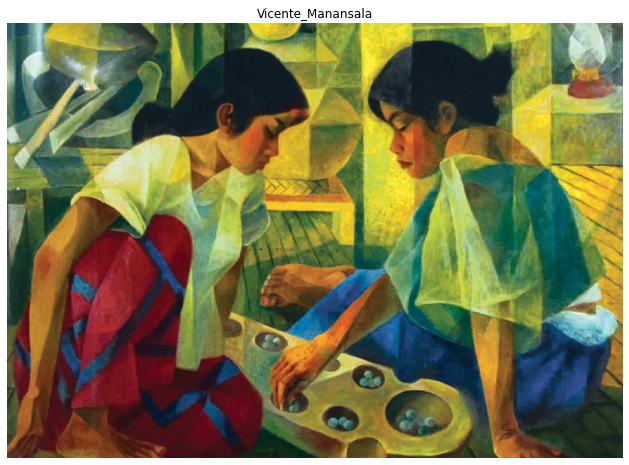

In [2]:
from sklearn.cluster import KMeans
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image

def show_image(image, image_name = "Image", figsize=(12,8)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    plt.title(image_name, )

# directory src
main_dir = "\\".join(os.getcwd().split("\\")[:-1])
img_dir = os.path.join(main_dir, "data", "style")

# get image 
img_name = "Vicente_Manansala.jpg"
src_img = os.path.join(img_dir, img_name)
img_name  = img_name.split(".")[0]
raw_image = Image.open(src_img)

# Preparing Image
image = np.reshape(raw_image,(-1, 3))
image.shape

# show image
show_image(raw_image, img_name)

## Color Extraction

- We use K-Means Clustering to extract the image's dominant color
- 10 cluster centers will be assigned
- a bar graph wil be plotted
- each of the color's plot size will correspond to the color's ratio

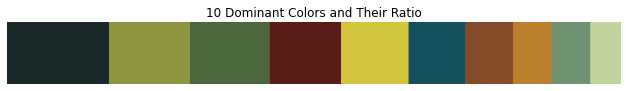

In [3]:
def clustering(image, n_clusters, print_info=False):
    # cluster the image colors
    kmeans = KMeans(n_clusters=n_clusters, random_state=2)
    kmeans.fit_predict(image)
    centers = kmeans.cluster_centers_.astype(int)

    # returns the labels for each pixel
    pxl = np.array(np.unique(kmeans.labels_, return_counts=True)[1], dtype=np.float32)
    pxl = pxl/image.shape[0] # gets the percentage

    # gets the dominant colors
    dom = [ [pxl[ix], centers[ix]] for ix in range(kmeans.n_clusters) ]
    dom = sorted(dom, reverse=True)

    # print
    if print_info:
        print("Cluster Centers:")
        for c in centers:
            print("\t", c)

        print("Dominant Colors")
        for d in dom:
            print("\t", d)

    return dom

def dominant_color_bar(color):
    color_bar = np.zeros((50,500,3), dtype="uint8")
    start = 0
    for c in color:
        width = round( (c[0])*color_bar.shape[1] )
        end = start+width
        color_bar[:,start:end, :] = c[1]
        start = end
    
    return color_bar


# get clustered colors
colors = clustering(image, n_clusters=10)
color_bar = dominant_color_bar(colors)
show_image(color_bar, "10 Dominant Colors and Their Ratio", figsize=(11, 5))

## Mood Analysis of Colors

- we use color psychology to get the color's meaning
- color usually represents emotion, mood, and sentiments
- in this study, we will use only red, green yellow, blue, purple, cyan


In [4]:
"""
color_RGB_1 ={
    "Red": [255, 0, 0],
    "Yellow": [255, 255, 0],
    "Blue": [0, 0, 255],
    "Green": [0, 255, 0],
    "Orange": [255, 128, 0],
    "Purple": [128, 0, 128],
    "Pink": [255, 192, 203],
    "Brown": [100, 70, 36],
    "White": [255, 255, 255],
    "Black": [0, 0, 0],
    "Grey": [128, 128, 128],
}

# we only use four for now
color_meaning_1 ={
    "Red": ("excitement", "strength", "love", "energy"),
    "Yellow": ("creativity", "happiness", "warmth", "cheer"),
    "Blue": ("trust", "peace", "loyalty", "competence"),
    "Green": ("nature", "healing", "freshness", "growth"),
    "Orange": ("confidence", "success", "bravery", "sociability"),
    "Purple": ("wisdom", "luxury", "spirituality", "ambition"),
    "Pink": ("compassion", "sincerity", "sophistication", "sweet"),
    "Brown": ("dependable", "rugged", "trustworthy", "simple"),
    "White": ("clean", "simplicity", "innocence", "honest"),
    "Black": ("formality", "bold", "mystery", "security"),
    "Grey": ("detachment", "neutral", "compromising", "conservative"),
}
"""

# smaller color sample for testing
color_RGB_2 ={
    "Red": [255, 0, 0],
    "Green": [0, 255, 0],
    "Blue": [0, 0, 255],
    "Yellow": [255, 255, 0],
    "Purple": [255, 0, 255],
    "Cyan": [0, 255, 255],
}
color_meaning_2 ={
    "Red": ("excitement", "strength", "love", "energy"),
    "Yellow": ("creativity", "happiness", "warmth", "cheer"),
    "Blue": ("trust", "peace", "loyalty", "competence"),
    "Green": ("nature", "healing", "freshness", "growth"),
    "Cyan": ("liveliness", "youth", "calmness", "health"),
    "Purple": ("wisdom", "luxury", "spirituality", "ambition"),
}

#  uses the color dictionary from above without slicing the tone
# converts the dictionary to list
def conv_to_list(color_RGB, has_black_white=False, n_tones = 0):
    color_RGB_tone = []
    for key, value in color_RGB.items():
        # slice the colors for tones
        if n_tones > 0:
            R = value[0] / 5
            G = value[1] / 5
            B = value[2] / 5
            for n in range(n_tones):
                color_RGB_tone.append((key, [R*(n+1), G*(n+1), B*(n+1)]))
        # no slicing
        else:
            color_RGB_tone.append((key, value))

    # for black and white
    if has_black_white:
        color_RGB_tone.append(('Black', [0.0, 0.0, 0.0,]))
        color_RGB_tone.append(('White', [255.0, 255.0, 255.0,]))

    return color_RGB_tone

color_RGB_ls = conv_to_list(color_RGB_2, n_tones=0)
color_RGB_ls


[('Red', [255, 0, 0]),
 ('Green', [0, 255, 0]),
 ('Blue', [0, 0, 255]),
 ('Yellow', [255, 255, 0]),
 ('Purple', [255, 0, 255]),
 ('Cyan', [0, 255, 255])]

### Color Equivalence

- we measure the distance between the 10 clustered colors and the 6 emotion colors
- each cluster color will be assign as one of the emotion colors 

In [5]:
# we use euclidean distances to get the similarity
# because we have color which has an RGB = 0, 0, 0 (black)

import numpy as np

def get_color_equivalent(colors, color_RGB, print_info = (False, False)):
    anchored_colors = []
    for color in colors: # iterrate clustered colors from the image
        color = color[1]
        nearest = float("inf") # declare high float value, get the nearest color
        # print(color)
        for (key, value) in color_RGB:
            distance = np.linalg.norm(color - value)
            # assign the closest color 
            if print_info[0]:
                print(f"{key}:{distance}")
            if distance < nearest:
                color_key = (key, value)
                nearest = distance
            
        if print_info[1]:
            print(f"{color_key[1]} = {color_key[0]} is nearest to {color} with distance of {nearest}")
        anchored_colors.append(color_key)
        
    return anchored_colors

color_equiv = get_color_equivalent(colors, color_RGB_ls, print_info =(False, True))

[0, 255, 0] = Green is nearest to [25 40 40] with distance of 220.11360703055138
[255, 255, 0] = Yellow is nearest to [144 150  63] with distance of 165.27250225007182
[0, 255, 0] = Green is nearest to [ 77 103  61] with distance of 180.9806619503863
[255, 0, 0] = Red is nearest to [89 29 25] with distance of 170.3584456374265
[255, 255, 0] = Yellow is nearest to [212 198  60] with distance of 93.26306878931231
[0, 0, 255] = Blue is nearest to [21 80 94] with distance of 181.00276240985937
[255, 0, 0] = Red is nearest to [133  75  40] with distance of 148.69095466772686
[255, 0, 0] = Red is nearest to [188 127  46] with distance of 150.77798247754876
[0, 255, 0] = Green is nearest to [110 145 113] with distance of 192.2732430682959
[255, 255, 0] = Yellow is nearest to [192 211 155] with distance of 173.0028901492689


### Color to Text Emotion
- we concatenate the percentage values of the clustered color if they are assign as the same emotion color
- n_emotions, refers to how many emotion colors will be extracted.
- we take the top (n_emotions) to return the respective emotion color and text.

In [6]:
def get_color_percentages(colors, color_equiv):
    # map the colors
    color_equiv_keys = [i[0] for i in color_equiv]
    color_map = []
    for idx, c in enumerate(colors):
        color_per = c[0]
        color_map.append((color_equiv_keys[idx], color_per))

    # get total percentage of color
    color_totals = {}
    for key, value in color_map:
        color_totals[key] = color_totals.get(key, 0) + value
    return color_totals


def get_dominant_emotions(color_list, color_meaning):
    # top color emotion
    # color_list = [key for key in color_totals][:n_emotions]
    emotions = []
    for key, value in color_meaning.items():
        if key in color_list:
            emotions.append((key, value))
    return emotions

def get_emotion_caption(colors, color_equiv, color_meaning = color_meaning_2, n_emotions=2):

    color_totals = get_color_percentages(colors, color_equiv)
    color_list = [key for key in color_totals][:n_emotions]
    color_dom_emo = get_dominant_emotions(color_list, color_meaning_2)


    # make sentence
    sentence = []
    for c in color_dom_emo:
        sentence.append(f" {', '.join(c[1])} because of the color {c[0]} which makes up about {color_totals[c[0]]:.2f}% of the image's color")
    
    caption = f"The {n_emotions} dominant colors of this image are {' and '.join(color_list)}."
    caption = " ".join((caption, "This image exudes", "; ".join(sentence)))

    return caption, color_dom_emo
caption, color_emo_map = get_emotion_caption(colors, color_equiv)
color_emo_map

[('Yellow', ('creativity', 'happiness', 'warmth', 'cheer')),
 ('Green', ('nature', 'healing', 'freshness', 'growth'))]

### Show Image

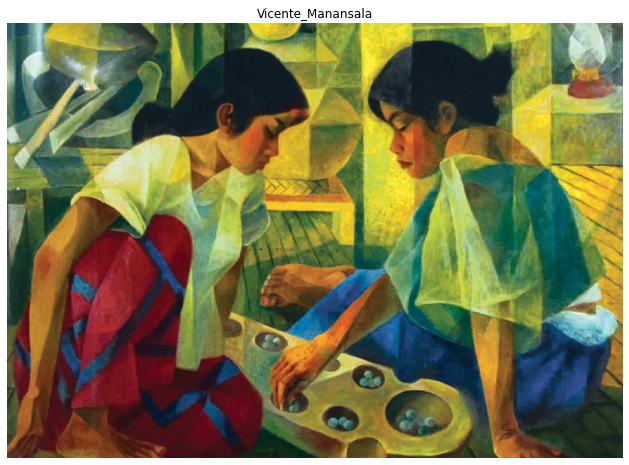

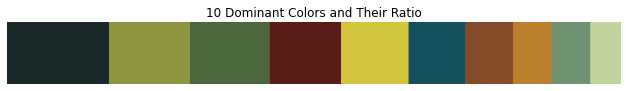

In [7]:
# show images
show_image(raw_image, img_name)
show_image(color_bar, "10 Dominant Colors and Their Ratio", figsize=(11, 5))

In [8]:
print(caption)

The 2 dominant colors of this image are Green and Yellow. This image exudes  creativity, happiness, warmth, cheer because of the color Yellow which makes up about 0.29% of the image's color;  nature, healing, freshness, growth because of the color Green which makes up about 0.36% of the image's color


# **Emotion Annotation of Paintings**

- compilation of above process to create an emotion annotation for each images
- create a csv file containing the filename and the emotion

In [9]:
# paths
main_dir = "\\".join(os.getcwd().split("\\")[:-1])
data_dir = os.path.join(main_dir, "data")
data_csv_dir = os.path.join(data_dir, "annotation_data")
content_dir = os.path.join(data_dir, "content")
style_dir = os.path.join(data_dir, "style")

In [13]:
import pandas as pd

# smaller color sample for testing
color_RGB_2 ={
    "Red": [255, 0, 0],
    "Green": [0, 255, 0],
    "Blue": [0, 0, 255],
    "Yellow": [255, 255, 0],
    "Purple": [255, 0, 255],
    "Cyan": [0, 255, 255],
}

color_meaning_2 ={
    "Red": ("excitement", "strength", "love", "energy"),
    "Yellow": ("creativity", "happiness", "warmth", "cheer"),
    "Blue": ("trust", "peace", "loyalty", "competence"),
    "Green": ("nature", "healing", "freshness", "growth"),
    "Cyan": ("liveliness", "youth", "calmness", "health"),
    "Purple": ("wisdom", "luxury", "spirituality", "ambition"),
}

def get_image_color_emotions(image, n_clusters=10, n_tones=0, n_emotions=2):
    image = np.reshape(image,(-1, 3))

    # cluster color
    print("Clustering...")
    colors = clustering(image, n_clusters)

    # slice or convert color sample dictionary to list
    color_RGB_ls = conv_to_list(color_RGB_2, n_tones=n_tones)

    # dominant colors to equivalent emotion color
    color_equiv = get_color_equivalent(colors, color_RGB_ls, print_info =(False, False))

    # get the emotions
    _, color_emo_map = get_emotion_caption(colors, color_equiv, n_emotions=n_emotions)

    return [c[1] for c in color_emo_map]

def get_emotions_annotation(style_imgs_ls, n_clusters=10, n_emotions=2):
    # get all of the images' emotion
    emo_feature = []
    for img in style_imgs_ls:
        # set image
        print(f"\nExtracting Emotions in {img}")
        img = os.path.join(style_dir, img)
        img = Image.open(img)

        # get emotion
        emo = get_image_color_emotions(image = img,  n_clusters=10, n_emotions=n_emotions)

        # make emotion list
        emo_list = np.array(emo)
        emo_list = emo_list.flatten()
        
        # emo_list = [";;".join(x) for x in emo]
        emo_list = ";;".join(emo_list)

        # x = ";;".join(x)
        emo_feature.append(emo_list)
    return emo_feature

# get the emotions of the reference images (style)
style_imgs_ls = os.listdir(style_dir)
emo_feature = get_emotions_annotation(style_imgs_ls, n_clusters=10, n_emotions=3)

# dataframe
df = pd.DataFrame({"filename": style_imgs_ls, "emotion": emo_feature})
df.to_csv(os.path.join(data_csv_dir, "annot_emo_paint.csv"), index=False)



Extracting Emotions in Ang_Kiukok.jpg
Clustering...

Extracting Emotions in Benedicto_Cabrera.jpg
Clustering...

Extracting Emotions in Fernando Amorsolo painting11.jpg
Clustering...

Extracting Emotions in Hernando_Ocampo.jpg
Clustering...

Extracting Emotions in Jose_Joya.jpg
Clustering...

Extracting Emotions in Jose_Joya2.jpg
Clustering...

Extracting Emotions in José Joya painting22.jpg
Clustering...

Extracting Emotions in Pacita Abad painting18.jpg
Clustering...

Extracting Emotions in Pacita Abad painting8.jpg
Clustering...

Extracting Emotions in Vicente_Manansala.jpg
Clustering...


## Data Annotation
- we now have an emotion annotation for paintings based on color psychology

In [12]:
df

,filename,emotion
0,Ang_Kiukok.jpg,creativity;;happiness;;warmth;;cheer;;trust;;p...
1,Hernando_Ocampo.jpg,trust;;peace;;loyalty;;competence;;nature;;hea...
2,Jose_Joya.jpg,excitement;;strength;;love;;energy;;creativity...
3,Vicente_Manansala.jpg,excitement;;strength;;love;;energy;;creativity...


# **Further Studies**

**Color Psychology and Meaning**
- http://www.arttherapyblog.com/online/color-psychology-psychologica-effects-of-colors/#.YUG_zivitPY
- http://www.arttherapyblog.com/online/color-meanings-symbolism/#.YUG_5CvisuU
- https://www.invaluable.com/blog/colors-and-emotions/
- https://www.truevaluepaint.com/color-101/color-psychology
- https://www.verywellmind.com/color-psychology-2795824
- https://londonimageinstitute.com/how-to-empower-yourself-with-color-psychology/
- https://royalsocietypublishing.org/doi/10.1098/rsos.190741


**Color Difference**
- https://en.wikipedia.org/wiki/Color_difference

**Emotions with Color Palettes**
- https://core.ac.uk/download/pdf/153368581.pdf
- https://www.researchgate.net/publication/232048151_Learning_moods_and_emotions_from_color_combinations


**Emotions from Paint Strokes**

**Face Emotions**